[View in Colaboratory](https://colab.research.google.com/github/iamthejao/DeepLearningLab-A1/blob/master/Assignment.ipynb)

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
sns.set_style('dark')
warnings.filterwarnings("ignore")

In [0]:
def create_dataset(w_star, x_range, sample_size, sigma, seed=None):
  random_state = np.random.RandomState(seed)
  x = random_state.uniform(x_range[0] , x_range[1] , (sample_size))
  X = np.zeros((sample_size , w_star.shape[0]))
  for i in range(sample_size):
    X[i, 0] = 1.
    for j in range(1, w_star.shape[0]):
      X[i, j] = x[i]**j
  y = X.dot(w_star).flatten()
  if sigma > 0:
    y += random_state.normal(0.0 , sigma , sample_size )
  return X, y



In [0]:
# Defining the Tensorflow environment to calculate the problem
def gradient_descent_linearRegression(Xtrain, ytrain, learning_rate, iterations, session=None, validation=None, print_interval=50, loss_chg_criteria=1E-6):
  
  # Setting TF variables
  X = tf.placeholder(tf.float32, shape=(None, Xtrain.shape[-1]))
  y = tf.placeholder(tf.float32, shape=(None,))
  w = tf.Variable(tf.zeros((Xtrain.shape[-1],1), dtype=tf.float32), trainable=True)
  
  # Mounting loss function
  prediction = tf.reshape(tf.matmul(X, w), (-1,))
  loss = tf.reduce_mean(tf.square(y - prediction))
  
  # Selecting optimizer
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  train = optimizer.minimize(loss)
  
  # Creating session
  if session is None:
    session = tf.Session()
    
  initializer = tf.global_variables_initializer()
  session.run(initializer)
  
  # Iterating training
  last_loss = None
  for i in range(iterations):
    l, _ = session.run([loss, train], feed_dict={X:Xtrain, y: ytrain})
    
    # Stop criteria
    if last_loss is None:
      last_loss = l
    else:
      diff = abs(l-last_loss)
      if diff < loss_chg_criteria:
        print("Finished in {0} iterations due to stop criteria of {1} loss change.".format(i+1, loss_chg_criteria))
        print("Loss: {0}".format(l))
        break
      else:
        last_loss = l
        
    if (i+1) % print_interval == 0:
      print("Iteration {0}. Loss: {1}.".format(i+1, l))
      
  # Check if validation set is given
  if validation is not None:
    Xval, yval = validation
    l = session.run(loss, feed_dict={X:Xval, y:yval})
    print("Validation loss: {0}".format(l))
   
  return session.run(w)

In [0]:
def plot(plot_dict):
  
  fontdict = {'fontsize':14, 'weight':"bold"}
  labels = plot_dict.keys()
  
  fig = plt.figure(figsize=(19,9))
  for label in labels:
    x = plot_dict[label][0][:,1].flatten()
    y = plot_dict[label][1]
    type_ = plot_dict[label][2]
    
    if type_ == "scatter":
      plt.scatter(x,y)
    elif type_ == "plot":
      plt.plot(x,y)
    else:
      pass
    plt.hold(True)
    
  plt.legend(labels, fontsize='medium')
  plt.title("Polynomial regression dataset comparison" , fontdict=fontdict)
  plt.xlabel("X", fontdict=fontdict)
  plt.ylabel("p(X) = xW", fontdict=fontdict)

In [0]:
w_star = np.array([-8, -4, 2, 1])[np.newaxis].T
x_range = [-3,2]
sample_size = 100
seed_train = 0
seed_validation = 1
sigma = 0.5

In [0]:
X_train, y_train = create_dataset(w_star, x_range, sample_size, sigma, seed=seed_train)
X_val, y_val = create_dataset(w_star, x_range, sample_size, sigma, seed=seed_validation)

In [202]:
w_train = gradient_descent_linearRegression(X_train, y_train, 0.01, 2000, validation=(X_val,y_val), print_interval=200)

Iteration 200. Loss: 2.6061182022094727.
Iteration 400. Loss: 0.5028912425041199.
Iteration 600. Loss: 0.2720271050930023.
Iteration 800. Loss: 0.24608522653579712.
Iteration 1000. Loss: 0.2431589961051941.
Finished in 1123 iterations due to stop criteria of 1e-06 loss change.
Loss: 0.2428840696811676
Validation loss: 0.21772891283035278


In [0]:
# Creating plot space for X
plot_size = 1000
x_plot = np.linspace(x_range[0], x_range[1], plot_size)
X_plot = np.ones((plot_size,1))
  X_plot = np.hstack((X_plot, (x_plot ** i)[np.newaxis].T))

y_trained = X_plot.dot(w_train).flatten()
y_generation = X_plot.dot(w_star).flatten()


In [0]:
plot_dict = {"Train dataset":[X_train, y_train, "scatter"],
             "Generator polynomial":[X_plot, y_generation, "plot"],
             "Regression Train (size=100, $\sigma$=0.5)":[X_plot, y_trained, "plot"]}

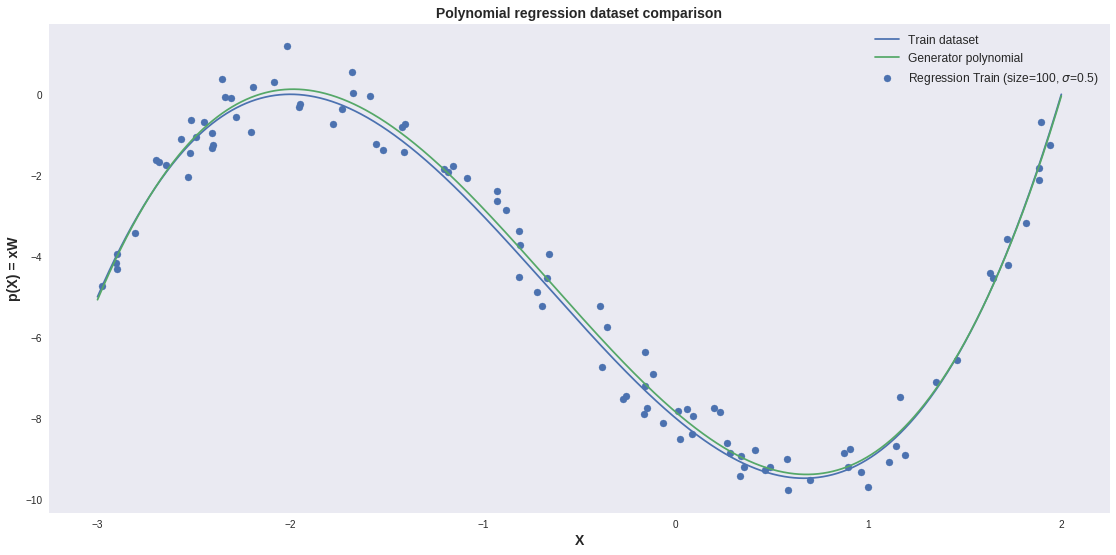

In [218]:
plot(plot_dict)